In [ ]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
from sklearn.metrics import confusion_matrix


In [2]:

# Load the image
def load_nifti(path):
    return nib.load(path).get_fdata()

# Gaussian Mixture Model (GMM) implemented from scratch
class GMM:
    def __init__(self, n_components, max_iters=100, tol=1e-4):
        self.n_components = n_components
        self.max_iters = max_iters
        self.tol = tol
        
    def initialize_params(self, X):
        self.means = np.random.choice(X, self.n_components)
        self.variances = np.full(self.n_components, np.var(X))
        self.weights = np.full(self.n_components, 1 / self.n_components)
    
    def e_step(self, X):
        responsibilities = np.zeros((len(X), self.n_components))
        for i in range(self.n_components):
            responsibilities[:, i] = self.weights[i] * norm.pdf(X, self.means[i], np.sqrt(self.variances[i]))
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        return responsibilities
    
    def m_step(self, X, responsibilities):
        N_k = responsibilities.sum(axis=0)
        self.weights = N_k / len(X)
        self.means = (responsibilities * X[:, np.newaxis]).sum(axis=0) / N_k
        self.variances = ((responsibilities * (X[:, np.newaxis] - self.means) ** 2).sum(axis=0)) / N_k
    
    def fit(self, X):
        self.initialize_params(X)
        for _ in range(self.max_iters):
            responsibilities = self.e_step(X)
            old_means = self.means.copy()
            self.m_step(X, responsibilities)
            if np.linalg.norm(self.means - old_means) < self.tol:
                break
    
    def predict(self, X):
        responsibilities = self.e_step(X)
        return np.argmax(responsibilities, axis=1)


In [3]:

# Load images
image_path = "./pics/sald_031764_img.nii"
csf_mask_path = "./pics/sald_031764_probmask_csf.nii"
gm_mask_path = "./pics/sald_031764_probmask_graymatter.nii"
wm_mask_path = "./pics/sald_031764_probmask_whitematter.nii"

image = load_nifti(image_path)
csf_mask = load_nifti(csf_mask_path)
gm_mask = load_nifti(gm_mask_path)
wm_mask = load_nifti(wm_mask_path)


In [4]:

# Flatten image for clustering
image_1d = image.flatten()
valid_mask = image_1d > 0  # Ignore zero intensity background
image_filtered = image_1d[valid_mask]


In [5]:

# Fit GMM
gmm = GMM(n_components=3)
gmm.fit(image_filtered)
labels = np.zeros_like(image_1d)
labels[valid_mask] = gmm.predict(image_filtered)
labels = labels.reshape(image.shape)


In [6]:
# Save the segmented image
segmented_image_path = "./pics/segmented_image.nii"
segmented_image = nib.Nifti1Image(labels, np.eye(4))
nib.save(segmented_image, segmented_image_path)

In [7]:

# Compute accuracy
segmentation_masks = [csf_mask, gm_mask, wm_mask]
pred_masks = [(labels == i).astype(float) for i in range(3)]
accuracy = [np.mean((pred_mask - true_mask) ** 2) for pred_mask, true_mask in zip(pred_masks, segmentation_masks)]


In [8]:

# Print accuracy
print("Segmentation Accuracy (MSE per label):")
print(f"CSF: {accuracy[0]:.4f}, Gray Matter: {accuracy[1]:.4f}, White Matter: {accuracy[2]:.4f}")


Segmentation Accuracy (MSE per label):
CSF: 0.7343, Gray Matter: 0.1144, White Matter: 0.1641


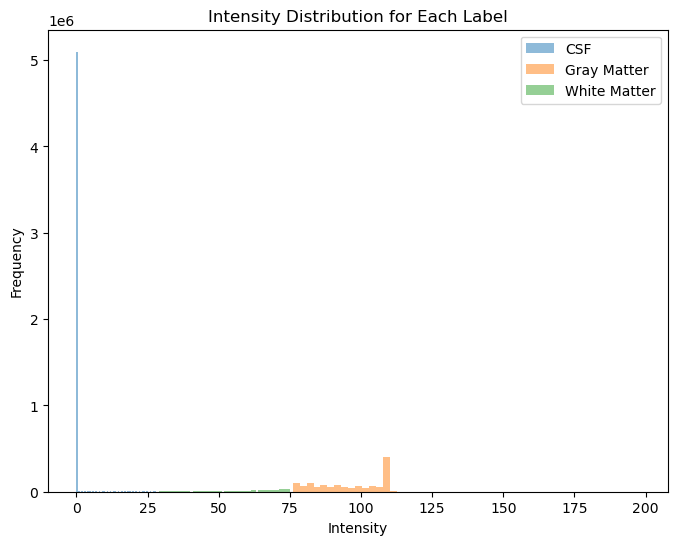

In [9]:

# Plot histogram
plt.figure(figsize=(8, 6))
for i, (label, name) in enumerate(zip(pred_masks, ["CSF", "Gray Matter", "White Matter"])):
    plt.hist(image[labels == i].flatten(), bins=50, alpha=0.5, label=name)
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.title("Intensity Distribution for Each Label")
plt.legend()
plt.show()


In [ ]:


# Flatten the true and predicted labels for the confusion matrix
true_labels = np.argmax(np.stack([csf_mask, gm_mask, wm_mask], axis=-1), axis=-1).flatten()
pred_labels = labels.flatten()

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Create a DataFrame for better visualization
conf_matrix_df = pd.DataFrame(conf_matrix, index=["True CSF", "True GM", "True WM"], columns=["Pred CSF", "Pred GM", "Pred WM"])

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix_df)

Confusion Matrix:
          Pred CSF  Pred GM  Pred WM
True CSF   5324322      532   220979
True GM          0   574975   380557
True WM          0   719667        0


### Misclassification
The highest misclassificaation occurs with grey matter - little below half of it gets classified as white matter
This is because the intensity ranges are quite closse to each other - making it diffiult for GMM to classifiy them.

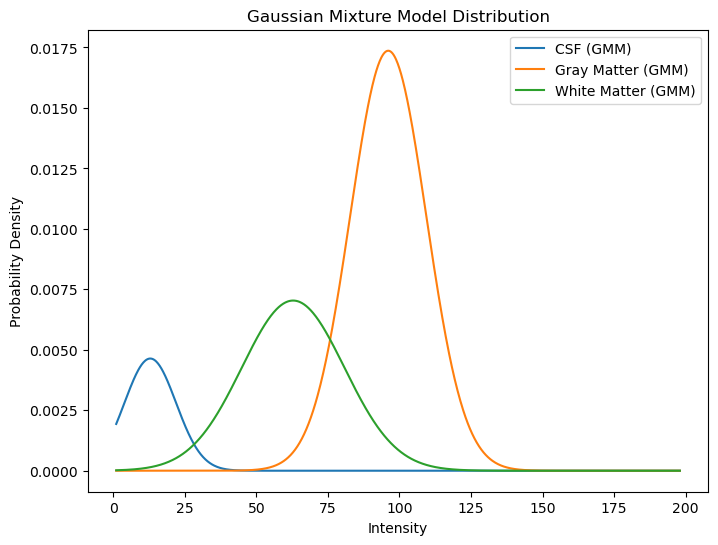

In [11]:
# Visualize GMM distribution
x_vals = np.linspace(image_filtered.min(), image_filtered.max(), 1000)
gmm_dists = [gmm.weights[i] * norm.pdf(x_vals, gmm.means[i], np.sqrt(gmm.variances[i])) for i in range(3)]

plt.figure(figsize=(8, 6))
for i, (dist, name) in enumerate(zip(gmm_dists, ["CSF", "Gray Matter", "White Matter"])):
    plt.plot(x_vals, dist, label=f"{name} (GMM)")
plt.xlabel("Intensity")
plt.ylabel("Probability Density")
plt.title("Gaussian Mixture Model Distribution")
plt.legend()
plt.show()